In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [2]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

In [3]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,K_max,S_max,N_test,f_type,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    num_basis_funcs = K_max+1
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(poly_vals)):
        poly_vals[k,:] = H(k,Noise)
    #initialize function
    f_vals_vanilla = X_test**2
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_2 = np.zeros_like(bar_a_1)
    for i in range(lag):
        #second-order coefficients
        bar_a_2[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(X_test[:-1]))**2
        bar_a_2[i,0] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(x0))**2
        #first-order coefficients
        bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(X_test[:-1])*(X_test[:-1]+gamma*b(X_test[:-1]))
        bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                        coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(x0)*(x0+gamma*b(x0))
    bar_a_1 = bar_a_1*poly_vals[1,:]
    bar_a_2 = bar_a_2*poly_vals[2,:]
    #compute martingale sums
    M_n_1 = 0.0
    M_n_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1 += bar_a_1[r,l]
            M_n_2 += bar_a_2[r,l]
    print("M_n_2: ",M_n_2)
    print("M_n_1: ",M_n_1)
    return np.mean(f_vals_vanilla),np.mean(f_vals_vanilla)-M_n_1/N_test,np.mean(f_vals_vanilla)-M_n_1/N_test-M_n_2/N_test

In [4]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        print("variance: ",np.var(y_all))
        print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [5]:
a = 5.0
c = 5.0
sig = 2.0

def b(X_t):
    """
    b function in the diffusion
    """
    return a*(c-X_t)

def sigma(X_t):
    """
    b function in the diffusion
    """
    return sig*np.sqrt(X_t)

def sample_discretized_diffusion(X_t,gamma_t):
    """
    args:   X_t - current value, 
            gamma_t - step size;
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn()
    return X_t + gamma_t*b(X_t) + np.sqrt(gamma_t)*sigma(X_t)*xi,xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros(n,dtype = float)
    noise_all = np.zeros(n,dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [6]:
n = 2*10**3 #sample size
gamma = 5e-2 # Step size
n_traj = 1
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "quadratic"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 50 #maximal lag order
N_test = 2*10**3

Sample discretized diffusion

In [7]:
x0 = 1
r_seed = 1812
X_train, noise_train = generate_traj(x0,n,gamma,r_seed)
#set target function
Y_train = X_train**2
X_train = X_train.reshape((1,-1,1))
Y_train = Y_train.reshape((1,-1,1))

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [8]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
for i in range(len(regr_vals)):
    for j in range(S_max+1):
        regr_vals[i,:] += coefs_poly[i,j]*X_train[0,:,0]**j

dimension =  2000
variance:  266.98152866407065
[ 3.40145826  6.00481932 12.66843187 18.20297372 13.82794416 10.1909413
 23.01213711 37.00213442 24.52690445 36.47752693 53.61712438 33.64413366
 24.2206685  28.5776758  32.18002758 11.93151358  8.03210523 10.44619265
 15.62951762 21.29375919 26.94373331 24.78759257 24.59313536 28.95088867
 28.16446026 44.85069779 40.74377703 49.12152741 41.7276258  47.72603542
 31.28994449 20.59617748 23.81359102 26.32599774 24.0988741  43.79950951
 59.23062885 39.91652065 20.11111713  6.39832153  4.39108588 14.65805425
 19.85690762 24.58031002 23.80034504 13.72537785 11.00866049 10.62603662
  5.98419378 15.08580262]
(2000, 3)
variance:  266.8441141126082
[ 6.00481932 12.66843187 18.20297372 13.82794416 10.1909413  23.01213711
 37.00213442 24.52690445 36.47752693 53.61712438 33.64413366 24.2206685
 28.5776758  32.18002758 11.93151358  8.03210523 10.44619265 15.62951762
 21.29375919 26.94373331 24.78759257 24.59313536 28.95088867 28.16446026
 44.85069779 

Test our regressors

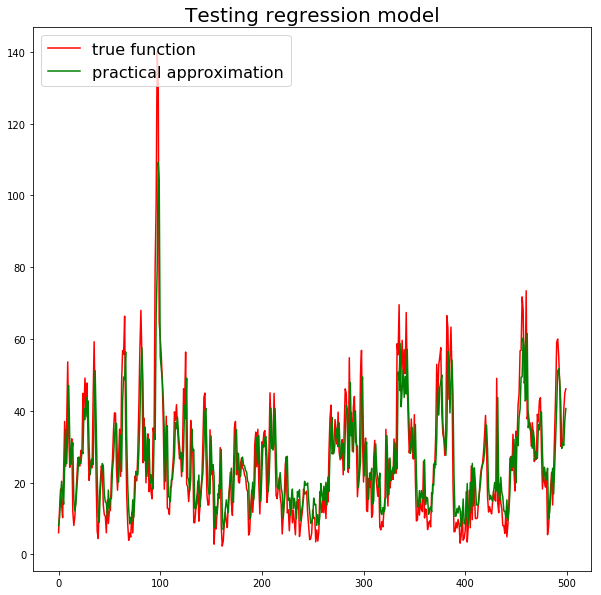

In [9]:
cur_lag = 1
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [10]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,lag,K_max,S_max,N_test,f_type,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

M_n_2:  42.22364732921469
M_n_2:  -156.88505479305795
M_n_1:  -3241.3222908184644
M_n_1:  3680.201058325199
M_n_2:  -130.09907457779806
M_n_1:  -278.45098832629594
M_n_2:  265.5725697585571
M_n_1:  755.0739295769255
M_n_2:  134.8543713592971
M_n_2:  87.19803011883333
M_n_2:  -437.38513234115226
M_n_1:  -432.94282441969665
M_n_1:  1998.4527501693678
M_n_1:  -792.3293735561981
M_n_2:  -100.34958645155471
M_n_1:  1301.6734949124561
M_n_2:  -178.88686524000047
M_n_1:  4833.079211358799
M_n_2:  266.8458571358705
M_n_2:  97.0076563230584
M_n_1:  566.1694944860872
M_n_1:  2374.0438772327802
M_n_2:  -36.822250298252854
M_n_1:  2063.130428555967
M_n_2:  104.88906034458364
M_n_2:  -135.0763895009685
M_n_1:  358.0864192157094
M_n_1:  1587.1938192735577
M_n_2:  126.8557252022195
M_n_1:  -1626.7739011869141
M_n_2:  115.367874004139
M_n_1:  654.4038386021166
M_n_2:  -185.55158024905109
M_n_2:  31.6899344460217
M_n_1:  90.06108374871322
M_n_1:  -883.1295307236148
M_n_2:  181.58479940131127
M_n_1:  67

In [11]:
res_new = np.asarray(res)
print(res_new.shape)

(100, 3)


### Comparison plots

In [12]:
title = ""
labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']#, 'ULA \nwith MDCV-2']

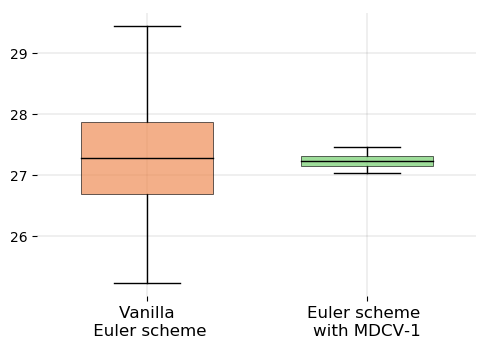

In [13]:
data = [res_new[:,0],res_new[:,1]]#,res_new[:,2]] 
boxplot_ind(data, title, labels,path="./diffusion_quadratic.pdf")